<style type="text/css">
	.myimg {
		max-width: 500px !important;
	}
</style>


# Monkey Type Machine Learn

**A Project by Richard McHorgh**


## Introduction


In the middle of October, inspired by YouTube creators, namely [Ben Vallack](https://www.youtube.com/benvallack), I began designing the printed circuit boards (PCBs), keycaps, and case plates that would eventually become the ortholinear, split, and thumb-maximizing keyboard I’m using to type this report. I thought it would be the perfect present for my birthday, but the main reason for starting this project was to protect my hands and wrists from the threat of carpal tunnel syndrome and other diseases like it.


Unlike the traditional row-staggered layout one would find on the majority of laptop and store-bought keyboards, ortholinear keyboards arrange the keys in a strict grid matrix. This allows for a more ergonomic and efficient typing experience, as each key is positioned directly under the finger that would normally press it, rather than back and shifted to the left or right by an arbitrary amount, thereby reducing strain on the fingers and wrists, and the risk of injuries such as carpal tunnel syndrome.


<img class='myimg' alt='A picture of the completed keyboard' src='/Users/richard/Documents/umd/cmsc320/final/img/kb_hat.jpg'/>

*A picture of the completed keyboard*

Furthermore, strain on the fingers, wrists, and back is reduced by the keyboard being split into halves between the positions of the 5 and 6 keys. Traditional keyboards require their users’ hands to be unnaturally close together, forcing their wrists to be at an angle, whereas, with a split keyboard, one’s hands can be straight and as far apart as the cable joining the two halves allows. Arms being in their natural position translates to hands being straight and in as comfortable of a position as possible, especially during long typing sessions.


<img class='myimg' src='/Users/richard/Documents/umd/cmsc320/final/img/strain.jpg'/>

_Hand angles while using a row staggered keyboard and a split keyboard_

The third ergonomic feature of the design are the programmable thumb clusters found on the last row of each half of the keyboard. Row staggered keyboards only use the operator’s thumbs for the spacebar, so to perform shortcuts with the Control, Command, Alt, or any other non-alphanumeric keys, hands must be moved off the keyboard. Each time the user’s fingers move off the home row introduces more strain. This strain is compounded when the entire hand must be moved to type a key. With a programmable thumb cluster, all movement (Up, Left, Home, etc.), page management (Alt-Tab), and text manipulation (Undo, Cut, Paste, etc.) shortcuts can be performed without lifting the hands from either half of the keyboard.


All the ergonomic design features of the keyboard would be less effective without a layout that can magnify them, so instead of the traditional QWERTY keyboard layout, my keyboard was programmed to use a slightly modified version of the Colemak-DHM layout that I named SemiColemak. Standard Colemak-DHM places letters on the keyboard by their frequency in English words and the relative strength of the finger that is meant to press them. The more common the letter, the stronger the finger above it. Contrarily, QWERTY is organized to minimize the jams of a typewriter, which is nonsensical in an era of electrically controlled keyboards.


However, due to QWERTY’s ubiquity, it was the keyboard layout I learned to type on in elementary school. Text manipulation shortcuts are based on the QWERTY layout as well, so SemiColemak’s proximity to QWERTY, with 11 keys in the same position, including z, x, c, and v, make it easier to learn compared to other ergonomic layouts such as Dvorak or Workman.


Although SemiColemak is among the easiest layouts for a transition from QWERTY, the relearning process has been as strenuous for my muscle memory as QWERTY was for my hands and wrists. Even now, in my third week of solely using the keyboard, my typing speed in SemiColemak is barely approaching half of my average on QWERTY.


The object of this tutorial is to identify the points of error in typing the words that I use most frequently and use that data to classify words featuring my weaknesses. Practicing this set of words, and other words that will help to increase my speed and accuracy typing on my keyboard.


## Collecting the raw data


As well as being the inspiration for this project's name, the competitive type racing website, Monkey See Monkey Type, which is generally abbreviated to Monkey Type, is the source of the data used in this project. By inserting the JavaScript keylogger written below into the Developer Mode Console in a browser, I was able to record the letter I pressed, the letter I should have pressed, and the source of the text, among other datapoints about the content of the test being taken.


In [1]:
%pycat data/scrape.js

var monkeyQueue = [];
var monkeyList = [];
var monkeyListen = () => {
        let layout, language, funbox, type, length, activeWord;
        let testNum = 0;

        let setup = () => {
                let words = document.querySelector('#words');
                monkeyQueue = Array.from(words.children).map((v, i, a) => {
                        return i < a.length - 1 ? `${v.innerText} ` : v.innerText;
                }, '');

                let options = Array.from(
                        document
                                .querySelector('#testModesNotice')
                                .querySelectorAll('[commands]')
                );

                layout = options.filter((e) => e.getAttribute('commands') == 'tags')[0]
                        .innerText;
                language = options.filter(
                        (e) => e.getAttribute('commands') == 'languages'
                )[0].innerText;
                let funboxElements = options.filter(
               

The data scraped from the above function is then sent to the [Deno](https://deno.land/) localhost webserver transcribed below. Once the POST request is received, the webserver appends it to a comma separated table. If you would like to use this code to analyze your own typing, make sure to start the Deno server before sending any data from the keylogger script.


In [2]:
%pycat data/save.ts

// import the webserver in the deno way
import { serve } from 'https://deno.land/std@0.157.0/http/server.ts';

type Input = {
        timestamp: Date;
        activeWord: string;
        lastChar: string;
        correctChar: string;
        layout: string;
        type: string;
        length: string;
        language: string;
        testNum: number;
        funbox: string;
};

const handler = async (req: Request) => {
        return await req
                .json()
                .then(async (test: Input[]) => {
                        for (let {
                                timestamp,
                                activeWord,
                                lastChar,
                                correctChar,
                                layout,
                                type,
                                length,
                                language,
                                funbox,
                                testNum
                        } of

## Understanding the data


### Required Imports 


In [3]:
from pandas import read_csv
from matplotlib.pyplot import subplots

In [4]:
df = read_csv("data/data.csv", keep_default_na=False)

### N-Grams


Although it rarely outputs actual words, the __Pseudolang__ funbox option generates words by algorithmically combining the common n-grams of the selected language. An n-gram is a sequence of two adjacent elements from a collection of tokens, and in this context, they are the likeliest letter sets. In English, some of the most common bigrams, or 2-grams, include:

-   th
-   he
-   in
-   er
-   an
-   re
-   nd
-   at
-   on
-   nt


Ingraining frequent n-grams into muscle memory is crucial to improving typing accuracy and speed. SemiColemak positions a few of these bigrams near each other, specifically in, he, at, and on, but underneath different fingers of the same hand. By avoiding the use of the same finger to type the n-gram, one can prime the finger assigned to the next letter in the sequence before the key is actually pressed, and as a product, decrease the time needed to type the whole word.


<img class='myimg' src='/Users/richard/Documents/umd/cmsc320/final/img/kb_legend.jpg'/>

_An image of the legend of the keyboard_

In [5]:
# Calculate the percentage of words with a listed n-gram in the entire dataset

ngrams = ["er", "re", "th", "in","an", "at", "he", "on", "nd",  "nt"]
for x in ngrams:
    print(
        f"Percentage of rows with {x} bigram:\t{round(len(df[df.activeWord.str.contains(x)]) * 100 / len(df))}%"
    )


Percentage of rows with er bigram:	12%
Percentage of rows with re bigram:	9%
Percentage of rows with th bigram:	6%
Percentage of rows with in bigram:	9%
Percentage of rows with an bigram:	6%
Percentage of rows with at bigram:	7%
Percentage of rows with he bigram:	4%
Percentage of rows with on bigram:	8%
Percentage of rows with nd bigram:	4%
Percentage of rows with nt bigram:	5%


### Languages


Monkey Type can generate typing tests in many different languages, so, in order to emulate the words that I use from day to day, about 72% of the tests that I took were comprised of English words, but since I write a lot of Python, JavaScript, C++ and Swift, to a lesser degree, French, those languages were added to the test mix.

Since all of the programming languages included use English-based syntax, they share many of the n-grams with English, however regular English does not train your fingers for coding paradigms like camel or snake case or using parentheses, equal signs, or comparators frequently.

<AxesSubplot:>

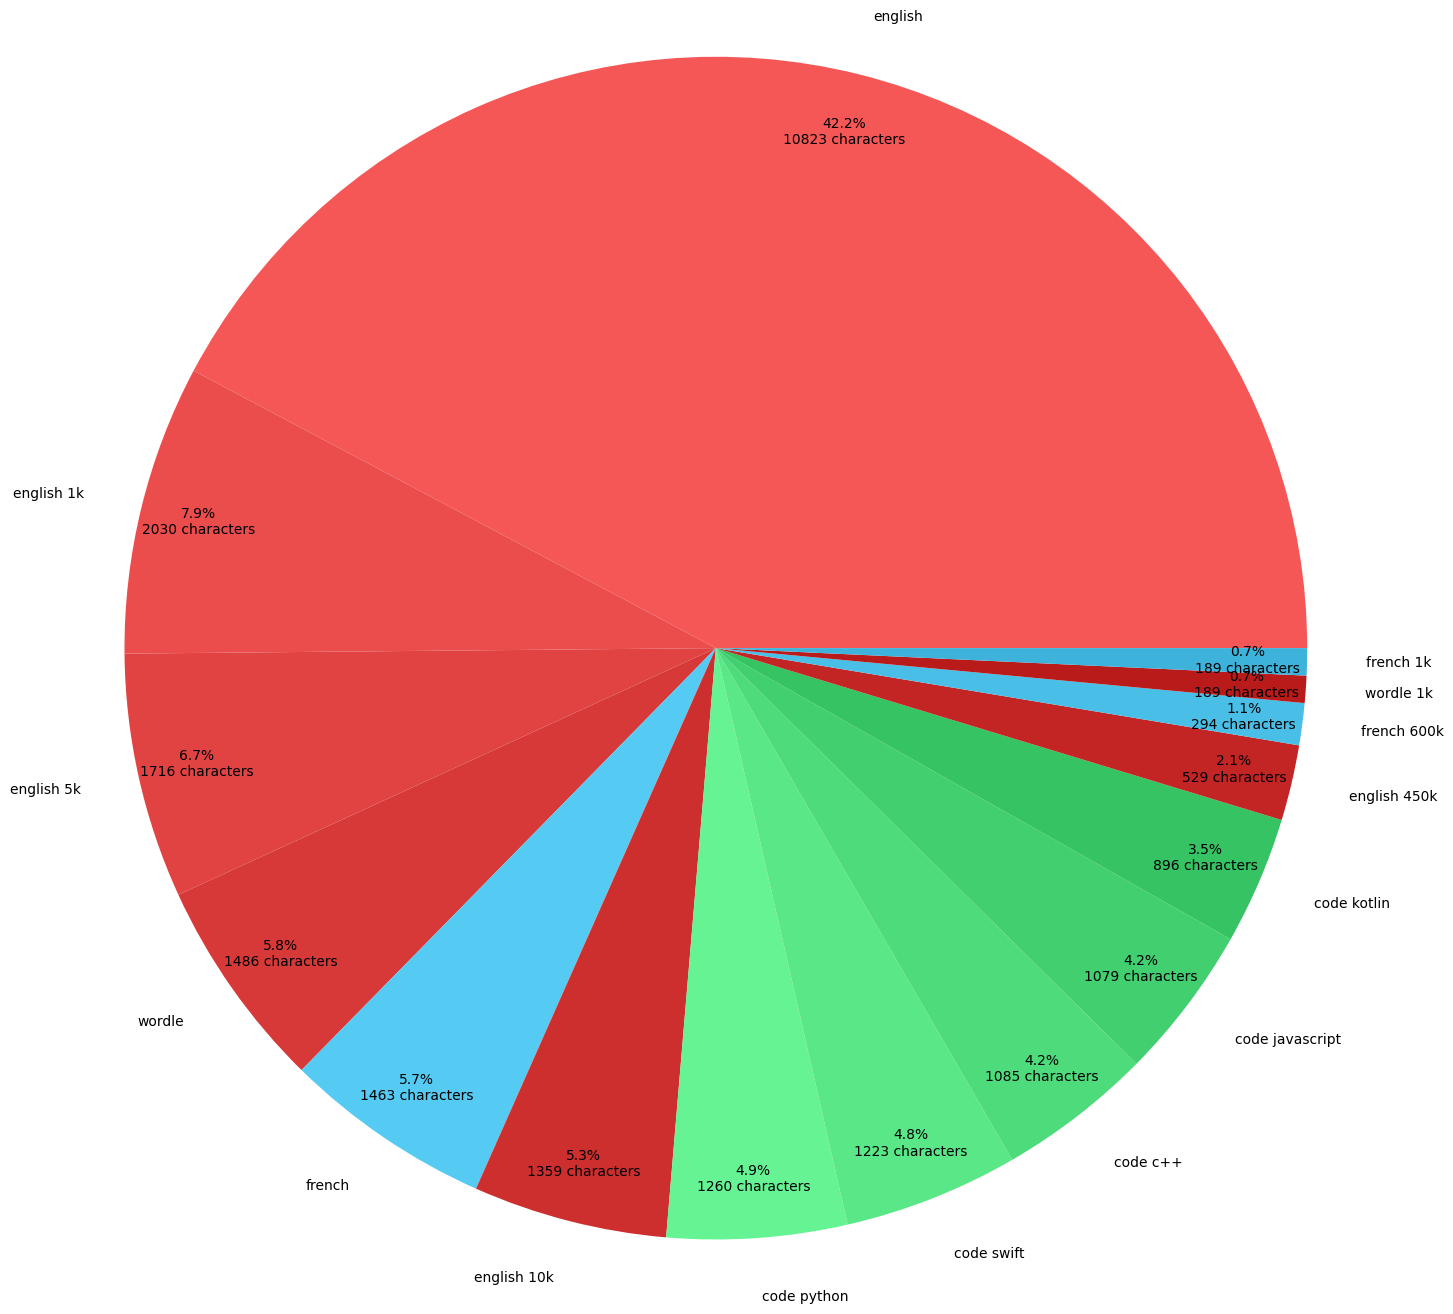

In [6]:
# Get value counts
v = df.language.value_counts()

# Generate color gradients
colors = [0] * 3

def pickColor(x):
    if "code" in x or 'git' in x:
        colors[0] += 1
        return "#" + "".join(
            [hex(c - (12 * colors[0]))[2:] for c in [0x71, 0xff, 0x9f]]
        )
    if "english" in x or "wordle" in x:
        colors[1] += 1
        return "#" + "".join(
            [hex(c - (10 * colors[1]))[2:] for c in [0xff, 0x61, 0x61]]
        )
    if "french" in x:
        colors[2] += 1
        return "#" + "".join(
            [hex(c - (12 * colors[2]))[2:] for c in [0x61, 0xD7, 0xff]]
        )

# Plot pie graph
v.plot.pie(
    radius=4,
    ylabel="",
	pctdistance=0.9,
    colors=[pickColor(x) for x in v.index],
    labels=v.index,
    autopct=lambda x: f"{round(x, 1)}%\n{int(x * v.sum() / 100)} characters",
)


_English language sets are depicted in various degrees of red, code sets in green, and French in blue._

### Punctuation 


When spoken languages are transcribed, punctuation marks are added. Monkey Type does not add these marks by default, so the **Quote** test __type__ was used to introduce them.


In [7]:
# Words with punctuation

df[df["activeWord"].str.contains("'")].head()

,timestamp,activeWord,lastChar,correctChar,layout,testNum,type,length,language,funbox
12907,2022-12-12T13:35:48.619Z,don't,d,d,semicolemakdh,1,quote,25,english,null
12908,2022-12-12T13:35:48.748Z,don't,o,o,semicolemakdh,1,quote,25,english,null
12909,2022-12-12T13:35:48.982Z,don't,n,n,semicolemakdh,1,quote,25,english,null
12910,2022-12-12T13:35:49.428Z,don't,',',semicolemakdh,1,quote,25,english,null
12911,2022-12-12T13:35:49.746Z,don't,t,t,semicolemakdh,1,quote,25,english,null


## Feature Engineering


The first step in identifying the points of error in my keyboard usage is to define a set of metrics to measure those errors. Once defined and computed, these metrics will be added as columns in the Pandas DataFrame. 

### Required Imports 


In [8]:
from datetime import datetime as dt, timedelta
from pandas import set_option
from numpy import NaN, nan

### Speed

Typing speed is calculated in characters per second rather than the customary unit of measurement, words per minute. Since there is a high variance in the length of words, using wpm would require some sort of averaging, which would invite information loss. Measuring characters per second does not necessitate averaging because it relies on the smallest non-temporal piece of data, the character. 

Characters per second is calculated by subtracting timestamps between two adjacent characters. This strategy works well when every letter typed is correct, however, since I am still learning, correctly typed characters inevitably precede mistypes. Instead of returning an accurate measurement of the useful characters typed per unit of time, the interval between characters simply returns raw typing speed. To remedy this, the speed of incorrectly typed characters is replaced with the mean of over the active word.

In [9]:
# Converting timestamps to python's date object

df.timestamp = df.timestamp.apply(lambda x: dt.fromisoformat(x[:-1]))
df.head()

,timestamp,activeWord,lastChar,correctChar,layout,testNum,type,length,language,funbox
0,2022-12-12 07:45:16.438,ninth,n,n,semicolemakdh,1,words,10,wordle,null
1,2022-12-12 07:45:16.527,ninth,i,i,semicolemakdh,1,words,10,wordle,null
2,2022-12-12 07:45:16.650,ninth,n,n,semicolemakdh,1,words,10,wordle,null
3,2022-12-12 07:45:16.881,ninth,t,t,semicolemakdh,1,words,10,wordle,null
4,2022-12-12 07:45:17.005,ninth,h,h,semicolemakdh,1,words,10,wordle,null


In [10]:
# Subtract the intervals

df["cps"] = df.timestamp
df.cps = df.cps.sub(df.timestamp.shift()).apply(lambda x: x.total_seconds())

# Show results
df[["timestamp", "lastChar", "cps"]].head()

,timestamp,lastChar,cps
0,2022-12-12 07:45:16.438,n,NaN
1,2022-12-12 07:45:16.527,i,0.089
2,2022-12-12 07:45:16.650,n,0.123
3,2022-12-12 07:45:16.881,t,0.231
4,2022-12-12 07:45:17.005,h,0.124


The intervals between letters in the same word and in the same test are correct, but since tests were not taken consecutively, some intervals are much too large.

In [11]:
df.iloc[[11019, 11020]]

,timestamp,activeWord,lastChar,correctChar,layout,testNum,type,length,language,funbox,cps
11019,2022-12-12 09:31:38.781,faut,t,t,semicolemakdh,79,words,10,french,null,0.556
11020,2022-12-12 13:14:29.763,mark,m,m,semicolemakdh,1,words,10,english 5k,null,13370.982


Although these letters were recorded successively, moving my fingers from the _t_ to _m_ key to begin the word _mark_ did not take nearly 4 hours. To ensure accuracy of the data, the beginning of the interval must align with the start of each test.

Tests taken in the same browser session are labeled in chronological order, but if the tab with running the logger was closed or refreshed, the order was reset to test number 1. Fixing the values in the __testNum__ column is necessary to get the correct cpms.

In [12]:
# Loop over each row
for i, _ in df.iterrows():
	if i + 1 == len(df):
		break

	tn = int(df.at[i, 'testNum'])
	ntn = int(df.at[i + 1, 'testNum'])
	
	# If the next row's num is less than the current row's (the rows are misordered)
	if tn > ntn:

		# Change all of the words in the next row's test to the correct number
		j = i + 1
		nln = df.at[j, 'length']
		lastWord = df.at[j, 'activeWord']
		while nln > 0 and j < len(df):
			df.at[j, 'testNum'] = tn + 1

			# If lastWord is different from this word
			if lastWord != df.at[j, 'activeWord']:
				lastWord = df.at[j, 'activeWord']
				nln -= 1

			# If row is the last of its word
			if lastWord[-1] != ' ' and j + 1 < len(df) and df.at[j + 1, 'activeWord'] != lastWord:
				break
			j += 1

Now that the tests are correctly indexed, we set the initial letter in each test to a null value.

In [13]:
# get the first characters in each list
firstChars = df.groupby('testNum').cps.head(1)

# set each start's cps to null value
for i in firstChars.index:
	df.loc[i, 'cps'] = NaN

df[df.testNum == 300].head()

,timestamp,activeWord,lastChar,correctChar,layout,testNum,type,length,language,funbox,cps
24132,2022-12-13 21:20:01.585,avancer,a,a,semicolemakdh,300,words,25,french 1k,null,NaN
24133,2022-12-13 21:20:01.715,avancer,v,v,semicolemakdh,300,words,25,french 1k,null,0.130
24134,2022-12-13 21:20:01.817,avancer,a,a,semicolemakdh,300,words,25,french 1k,null,0.102
24135,2022-12-13 21:20:02.057,avancer,n,n,semicolemakdh,300,words,25,french 1k,null,0.240
24136,2022-12-13 21:20:02.400,avancer,c,c,semicolemakdh,300,words,25,french 1k,null,0.343


### Consistency

Consistency is the measure of the difference in characters per second across the letters of a word. Analyzing the consistency between keypresses will determine the bi and trigrams that require the most practice.

$$\text{consistency score} = \text{cps}_i - \text{cps}_{i - 1}$$

_Lower is better_

In [14]:
# Subtract the time to press character_i from time to press character_i-1
df['consistency'] = df.cps
df.consistency = df.consistency.sub(df.cps.shift())

# Replace NaN value of the second words with the cps
df.consistency = df.consistency.fillna(df.cps)

# Show results
df[['lastChar', 'cps', 'consistency']].head()

,lastChar,cps,consistency
0,n,NaN,NaN
1,i,0.089,0.089
2,n,0.123,0.034
3,t,0.231,0.108
4,h,0.124,-0.107


### Accuracy

Another important metric for identifying the points of typing errors is accuracy. It will be calculated by dividing the number of keypresses taken to correctly type a word by the number of characters in that word, then subtracting that number from 1. 

$$\text{accuracy score} = \frac{\text{keypresses to type correctly}}{\text{length of word}} - 1$$ 

_Zero is perfect, Less than zero is a partially completed word, More than zero has more keypresses than necessary_

In [23]:
# Add column
df['acc'] = NaN

# Loop over the beginning of every word
i = 0
while i < len(df) - 1:
	aw = df.activeWord.iloc[i]

	j = i + 1
	naw = df.activeWord.iloc[j]

	# Find the end of the word
	while j < len(df) - 1 and aw == naw:
		j += 1
		naw = df.activeWord.iloc[j]

	# Set the column values in the word to the accuracy score
	for k in range(i, j + 1): 
		df.at[k, 'acc'] = ((j - i) / len(aw)) - 1

	i = j

# Show results
df[['activeWord', 'lastChar', 'acc']].head(13)

,activeWord,lastChar,acc
0,ninth,n,0.000000
1,ninth,i,0.000000
2,ninth,n,0.000000
3,ninth,t,0.000000
4,ninth,h,0.000000
5,ninth,,0.000000
6,droop,c,0.166667
7,droop,d,0.166667
8,droop,r,0.166667
9,droop,o,0.166667


### Reach Length

On most keyboards, my custom included, some of the keys are spaced further from the home row than others. While on the left hand, the keys for Q, W, F, and P are just one row up, keys like B and its corresponding key on the right hand, J, require the index finger to move up and to the left in order to press it.  

Values in the __reachLength__ column will be a ratio of their distance to the nearest finger on the home row to the standard distance between keys. Since the distance traveled to press a key directly above the home row is 19 mm, pressing a key on the inner column like B, J, V or K, requires the index finger to move $19 \sqrt{2}$ mm, so the value for B would be 1.4. For keys that require either of the shift keys to be pressed, an extra 1.4 must be added to their __reachLength__ because the shift keys are 1.4 units away from the pinkies.

Symbol keys like _, -, +, and = require a combination of the left shift and the first row of the right board, which are 2 units from the home row, so their total is 3.4. , are typed with left shift and period key which is 1 unit from the home row. ? and ! are both mapped to the combination of the 1 key and the left and right shift keys, respectively. This means that ! costs the same movement as +, -, or =, but ? costs 5, because it requires the left pinky to move to the left shift, 1.4 units, and the left ring finger to move to the 1 key or 3.6 units.

In [18]:
def reachLength(x):
	# Is the key more than 1 unit away
	char = 'shiftReq' if x.lower() != x or x in [',', '-', '_', '+', '=', '!', '?'] else x

	# Is the key in the middle column
	if char in 'bvjk':
		return 1.4
	# Does the key need a shift key
	elif char == 'shiftReq':
		if x in ['_', '-', '+', '=', '!']:
			return 3.4
		elif x == '?':
			return 5
		elif x == ',':
			return 2.4
		# Is the key a capital letter
		return 1.4 + reachLength(x.lower())
	# Is the key on the home row
	elif char in 'asrtnei;':
		return 0
	# Every other key
	else:
		return 1

# Apply the above function to the dataset
df['reachLength'] = df.correctChar.apply(reachLength)

# Show results
df[['correctChar', 'reachLength']].head()

,correctChar,reachLength
0,n,0.0
1,i,0.0
2,n,0.0
3,t,0.0
4,h,1.0


### Aggregate Typing Score

All 4 of these datapoints will be aggregated into a single score that balances the difficulty of pressing the key and my accuracy and speed when I press it. If the speed, consistency, or accuracy were to be analyzed independently, the fact that farther keys taking more time to press would be overlooked. 

## Analysis

## Remove later


In [17]:
!jupyter nbconvert --to html main.ipynb --output-dir='docs' --output='index.html'

[NbConvertApp] Converting notebook main.ipynb to html
[NbConvertApp] Writing 899588 bytes to docs/index.html
